In this kernel, we use efficientnet to complete the binary classification task. **This kernel is especially helpful if you are making an introduction to computer vision and deep learning in general**. In order to solve this challenge, the steps I take are the following:
1. Specify where the training and test folders are
2. Visualize a few images to know what data we're dealing with
3. Use Keras's ImageDataGenerator to augment the training data. If you haven't used this library before, or are new to data augmentation, take a look at this link: [http://keras.io/preprocessing/image/](http://)
4. We use a pre-trained model called EfficientNet. You don't need to know how this works. We just feed the data to the model we obtain online, and it gives us a good accuracy.
5. We finally make our predictions on the test images in the test zip file and format the submission.csv file to hold our own submissions!


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'train.csv', 'sample_submission.csv', 'test']


1. Installing pre-trained model - EfficientNet

In [2]:
!pip install -U efficientnet

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


2. Specifying Train and Test directories

In [3]:
train_dir = '../input/train/train'
test_dir = '../input/test'
train_df = pd.read_csv('../input/train.csv')
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


3. Visualising a few cactuses and non-cactuses

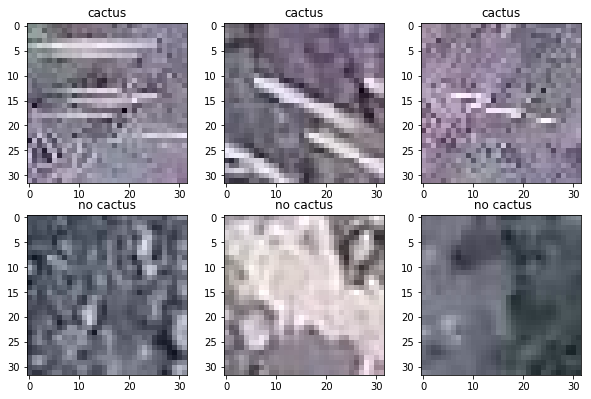

In [4]:
import cv2
cactus = []
cactus.append(cv2.imread(train_dir + '/' + train_df['id'][0]))
cactus.append(cv2.imread(train_dir + '/' + train_df['id'][1]))
cactus.append(cv2.imread(train_dir + '/' + train_df['id'][2]))
#now reading no cactus images
cactus.append(cv2.imread(train_dir + '/' + train_df['id'][6]))
cactus.append(cv2.imread(train_dir + '/' + train_df['id'][7]))
cactus.append(cv2.imread(train_dir + '/' + train_df['id'][11]))


labels = ['cactus','cactus','cactus','no cactus','no cactus',' no cactus']

import matplotlib.pyplot as plt

plt.figure(figsize=[10,10])
for x in range(0,6):
    plt.subplot(3, 3,x+1)
    plt.imshow(cactus[x])
    plt.title(labels[x])
    x += 1
    
plt.show()

Takeout: Might be a little difficult to recognise between the two categories. Each image is 32x32 pixels. Now that we know the data we are dealing with, lets try to augment the data. Before that, Let's import a few libraries we need for our EfficientNet

In [5]:
from keras import applications
from efficientnet import EfficientNetB3
from keras import callbacks
from keras.models import Sequential

Using TensorFlow backend.


In [6]:
train_df['has_cactus'] = train_df['has_cactus'].astype('str')

Before we move on, a little explanation on ImageDataGenerator:
* we generate two generators - one for training, and another for validation. These are stored in train_generator and val_generator. For both, we apply a series of distortions. 
* However, instead of storing all these new images in a directory, we use the method **flow_from_dataframe** to dynamically load these images as we train the model
* However, all the distortions we made for train_gen are not applied to test_gen. This is because we don't want to augment the data in the test directory.

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.10,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col="id",
    y_col="has_cactus",
    target_size=(32,32),
    subset="training",
    batch_size=1024,
    shuffle=True,
    class_mode="binary"
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col="id",
    y_col="has_cactus",
    target_size=(32,32),
    subset="validation",
    batch_size=256,
    shuffle=True,
    class_mode="binary"
)

Found 15750 images belonging to 2 classes.
Found 1750 images belonging to 2 classes.


In [8]:
test_datagen = ImageDataGenerator(
    rescale=1/255
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32,32),
    batch_size=1,
    shuffle=False,
    class_mode=None
)

Found 4000 images belonging to 1 classes.


Now, we used the pre-trained EfficientNet Model. The weights we used are the 'imagenet' weights. These weights are trained for object classification. This can really help our model because we don't have to train from scratch. 

This is the reason we set the include_top parameter of the EfficientNet to False. Essentially, we use the already trained initial layers - which detects lower-level features like edges, etc. Our EfficientNet is very good at this. We then replace the top layers with our own dense layers to recognise higher level features : like cactus or not. This is called **Transfer Learning**

For more on Transfer learning, see [https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html](http://)


In [9]:
from keras.layers import Dense
from keras.optimizers import Adam

efficient_net = EfficientNetB3(
    weights='imagenet',
    input_shape=(32,32,3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
43974656/43966704 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 1536)              10783528  
_________________________________________________________________
dense_1 (Dense)              (None, 120)               184440    
_________________________________________________________________
dense_2 (Dense)              (None, 120)               14520     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 121       
Total params: 10,982,609
Trainable params: 10,895,313
Non-trainable params: 87,296
___

After we build or model, we compile it. We use Adam as the optimizer (safest choice)

In [10]:
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

Finally, we train the network with 51 epochs!

In [11]:
history = model.fit_generator(
    train_generator,
    epochs = 50,
    steps_per_epoch = 15,
    validation_data = val_generator,
    validation_steps = 7
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
15/15 [==============================] - 55s 4s/step - loss: 0.6697 - acc: 0.5419 - val_loss: 0.5296 - val_acc: 0.7389
Epoch 2/50
15/15 [==============================] - 21s 1s/step - loss: 0.4398 - acc: 0.8207 - val_loss: 0.3613 - val_acc: 0.8846
Epoch 3/50
15/15 [==============================] - 24s 2s/step - loss: 0.2992 - acc: 0.8987 - val_loss: 0.2270 - val_acc: 0.9303
Epoch 4/50
15/15 [==============================] - 23s 2s/step - loss: 0.2066 - acc: 0.9323 - val_loss: 0.1332 - val_acc: 0.9560
Epoch 5/50
15/15 [==============================] - 23s 2s/step - loss: 0.1496 - acc: 0.9490 - val_loss: 0.1262 - val_acc: 0.9543
Epoch 6/50
15/15 [==============================] - 23s 2s/step - loss: 0.1169 - acc: 0.9607 - val_loss: 0.1115 - val_acc: 0.9629
Epoch 7/50
15/15 [==============================] - 24s 2s/step - loss: 0.0948 - acc: 0.9673 - val_loss: 0.1159 - val_acc: 0.9651
Epoch 8/50
15/15 [========================

Now that we have trained the network, let's plot the training vs validation accuracy and loss

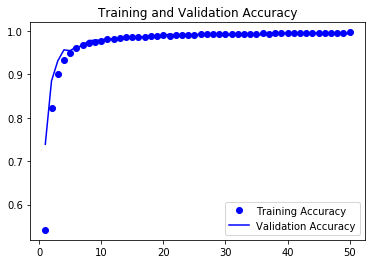

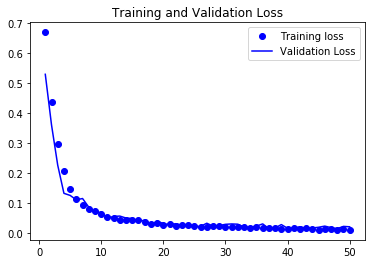

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()




From the plots, we see that the model has not overfit. Training and validation accuracy are almost the same. Now, lets generate our predictions

In [13]:
preds = model.predict_generator(
    test_generator,
    steps=len(test_generator.filenames)
)

In [14]:
image_ids = [name.split('/')[-1] for name in test_generator.filenames]
predictions = preds.flatten()
data = {'id': image_ids, 'has_cactus':predictions} 
submission = pd.DataFrame(data)
print(submission.head())

                                     id  has_cactus
0  000940378805c44108d287872b2f04ce.jpg    0.999246
1  0017242f54ececa4512b4d7937d1e21e.jpg    0.999878
2  001ee6d8564003107853118ab87df407.jpg    0.001363
3  002e175c3c1e060769475f52182583d0.jpg    0.000116
4  0036e44a7e8f7218e9bc7bf8137e4943.jpg    0.999871


Finally, we generate the submission file! After this, go ahead and commit!

In [15]:
submission.to_csv("submission.csv", index=False)